In [1]:
import pandas as pd
from pathlib import Path

import pytorch_lightning
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.core.module import LightningModule
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
data_path = Path("/Users/olipina001/Downloads/ecg_data")
df_train = pd.read_csv(data_path / "ECG_mitbih_train.csv", header=None)

# Data Exploration

In [5]:
df_train.rename(columns={187: 'class'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
df_train['label'] = df_train.iloc[:, -1].map(id_to_label)

x_train = df_train.loc[:, (df_train.columns != "label") & (df_train.columns != "class")]
y_train = df_train['class']

<Axes: >

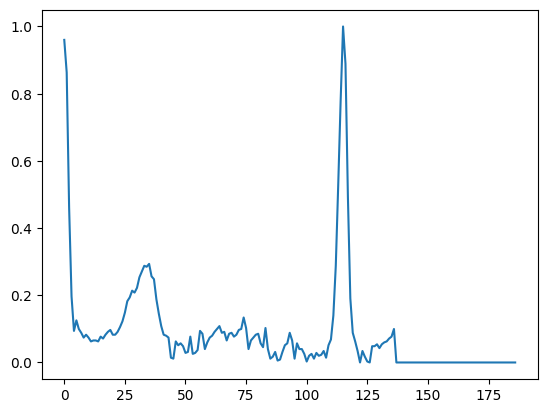

In [6]:
x_train.loc[1, :].plot()

<Axes: >

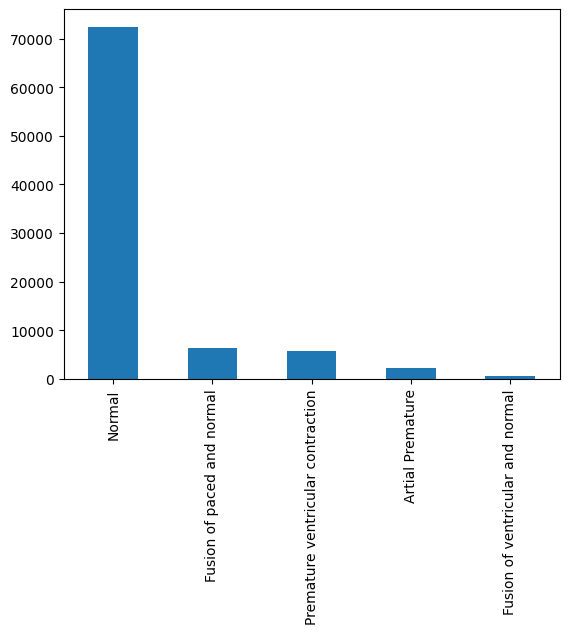

In [7]:
df_train['label'].value_counts().plot.bar()

# Datamodule

In [8]:
df_train.columns

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
           179,     180,     181,     182,     183,     184,     185,     186,
       'class', 'label'],
      dtype='object', length=189)

In [20]:
class ECGDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.data_columns = list(range(187))
    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype(float)
        signal_tensor = torch.FloatTensor(signal)
        signal_tensor = signal_tensor.unsqueeze(dim=0)
        label_5d = [0]*5
        real_label = self.df.loc[idx, "class"].astype(int)
        label_5d[real_label] = 1
        label = torch.Tensor(label_5d)
        return signal_tensor, label

    def __len__(self):
        return len(self.df)

class ECGDataModule(pl.LightningDataModule):
    def __init__(self, df, batch_size = 16):
        super().__init__()
        self.df = df
        self.batch_size = batch_size
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.dataset = ECGDataset(self.df)

            self.data_train, self.data_validation = random_split(self.dataset,
                                                                 [round(len(self.dataset) * 0.8),
                                                                  round(len(self.dataset) * 0.2)])
        elif stage == "test":
            self.dataset = ECGDataset(self.df)
    def train_dataloader(self):
        return DataLoader(self.data_train, batch_size=self.batch_size, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self.data_validation, batch_size=self.batch_size, shuffle=True)
    def test_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)



In [26]:
# dm = ECGDataModule(df_train)
# dm.setup()
# loader = dm.train_dataloader()
# obj = next(iter(loader))

In [27]:
# obj

# RNN

In [28]:
# class ConvNormPool(nn.Module):
#     """Conv Skip-connection module"""
#     def __init__(
#         self,
#         input_size,
#         hidden_size,
#         kernel_size,
#         norm_type='bachnorm'
#     ):
#         super().__init__()
#
#         self.kernel_size = kernel_size
#         self.conv_1 = nn.Conv1d(
#             in_channels=input_size,
#             out_channels=hidden_size,
#             kernel_size=kernel_size
#         )
#         self.conv_2 = nn.Conv1d(
#             in_channels=hidden_size,
#             out_channels=hidden_size,
#             kernel_size=kernel_size
#         )
#         self.conv_3 = nn.Conv1d(
#             in_channels=hidden_size,
#             out_channels=hidden_size,
#             kernel_size=kernel_size
#         )
#
#         if norm_type == 'group':
#             self.normalization_1 = nn.GroupNorm(
#                 num_groups=8,
#                 num_channels=hidden_size
#             )
#             self.normalization_2 = nn.GroupNorm(
#                 num_groups=8,
#                 num_channels=hidden_size
#             )
#             self.normalization_3 = nn.GroupNorm(
#                 num_groups=8,
#                 num_channels=hidden_size
#             )
#         else:
#             self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
#             self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
#             self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)
#
#         self.pool = nn.MaxPool1d(kernel_size=2)
#
#     def forward(self, input):
#         conv1 = self.conv_1(input)
#         x = self.normalization_1(conv1)
#         x = nn.SiLU(x)
#         x = F.pad(x, pad=(self.kernel_size - 1, 0))
#
#         x = self.conv_2(x)
#         x = self.normalization_2(x)
#         x = nn.SiLU(x)
#         x = F.pad(x, pad=(self.kernel_size - 1, 0))
#
#         conv3 = self.conv_3(x)
#         x = self.normalization_3(conv1+conv3)
#         x = nn.SiLU(x)
#         x = F.pad(x, pad=(self.kernel_size - 1, 0))
#
#         x = self.pool(x)
#         return x

In [29]:
# import numpy as np
# from sklearn.metrics import mean_squared_error
#
#
# class RNNModel(LightningModule):
#     def __init__(self, input_size, hidden_size, kernel_size, num_layers=1, lr=0.001):
#         super().__init__()
#         self.n_classes = 5
#         self.lr = 0.001
#         self.conv1 = ConvNormPool(
#             input_size=input_size,
#             hidden_size=hidden_size,
#             kernel_size=kernel_size,
#         )
#         self.conv2 = ConvNormPool(
#             input_size=hidden_size,
#             hidden_size=hidden_size,
#             kernel_size=kernel_size,
#         )
#         self.rnn_layer = nn.RNN(input_size, hidden_size, num_layers, dropout=0.1, bidirectional=True)
#
#         self.avgpool = nn.AdaptiveAvgPool1d((1))
#         self.fc = nn.Linear(in_features=hidden_size, out_features=self.n_classes)
#
#     def forward(self, input):
#         x = self.conv1(input)
#         x = self.conv2(x)
#         x, _ = self.rnn_layer(x)
#         x = self.avgpool(x)
#         x = x.view(-1, x.size(1) * x.size(2))
#         x = F.softmax(self.fc(x), dim=1)#.squeeze(1)
#         return x
#     def configure_optimizers(self):
#         optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.lr)
#         return optimizer
#
#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         y_hat = self.forward(x)
#         loss = nn.CrossEntropyLoss()(y_hat, y)
#         self.log("training_loss", loss, on_epoch=True,
#                  on_step=True, prog_bar=True)
#         return loss
#     def validation_step(self, val_batch, batch_idx):
#         x, y = val_batch
#         y_hat = self.forward(x)
#         loss = nn.CrossEntropyLoss()(y_hat, y)
#         self.log('val_loss', loss, on_epoch=True, prog_bar=True)
#         return loss
#     def test_step(self, batch, batch_idx):
#         x, y = batch
#         y_hat = self.forward(x)
#         rmse = np.sqrt(mean_squared_error(y, y_hat.detach().numpy()))
#         # self.log('roc_auc', roc_auc)
#         self.log('rmse', rmse)
#         return {"rmse": rmse,
#                 "y_true": y, "y_pred": y_hat}
#
#
#   # nn.CrossEntropyLoss()

# LSTM


In [32]:
from OTHER.ecg_lab import RNNModel

dm = ECGDataModule(df_train)
trainer = pl.Trainer()
model = RNNModel(input_size=1, hidden_size=64, kernel_size=5, lr=0.001)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Hallo!


/Users/olipina001/Workspace/Other/Stroke_Prediction/.venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [33]:
trainer.fit(model, dm)

/Users/olipina001/Workspace/Other/Stroke_Prediction/.venv/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

  | Name      | Type              | Params
------------------------------------------------
0 | conv1     | ConvNormPool      | 41.9 K
1 | conv2     | ConvNormPool      | 62.0 K
2 | rnn_layer | RNN               | 14.3 K
3 | avgpool   | AdaptiveAvgPool1d | 0     
4 | fc        | Linear            | 325   
------------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.474     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/olipina001/Workspace/Other/Stroke_Prediction/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/olipina001/Workspace/Other/Stroke_Prediction/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/olipina001/Workspace/Other/Stroke_Prediction/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which m

Training: 0it [00:00, ?it/s]

/Users/olipina001/Workspace/Other/Stroke_Prediction/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# GRU